In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_datasets as tfds
import os
import pickle
from sklearn.model_selection import train_test_split

In [2]:
gpu = tf.config.list_physical_devices('GPU')
print(gpu)

[]


## Load Cifar 100 

In [3]:
ds = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [17]:
(X_train, y_train), (X_test, y_test) = ds
X_val, y_val = train_test_split((X_train, y_train), test_size=0.2)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

### using tf.data.Dataset 

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [19]:
print(f"training data number of samples : {tf.data.experimental.cardinality(train_ds)}")
print(f"testing data number of samples : {tf.data.experimental.cardinality(test_ds)}")
print(f"validation data number of samples : {tf.data.experimental.cardinality(validation_ds)}")
print(f"data shape : {train_ds}")

training data number of samples : 50000
testing data number of samples : 10000
validation data number of samples : 1
data shape : <TensorSliceDataset shapes: ((32, 32, 3), (100,)), types: (tf.uint8, tf.float32)>


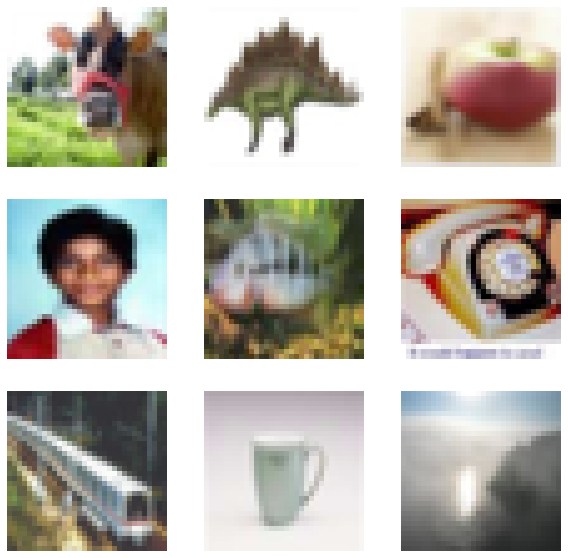

In [22]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [23]:
batch_size = 32 
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Data Augmentation

In [24]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
        #added
        keras.layers.experimental.preprocessing.RandomContrast((0,1))
    ]
)

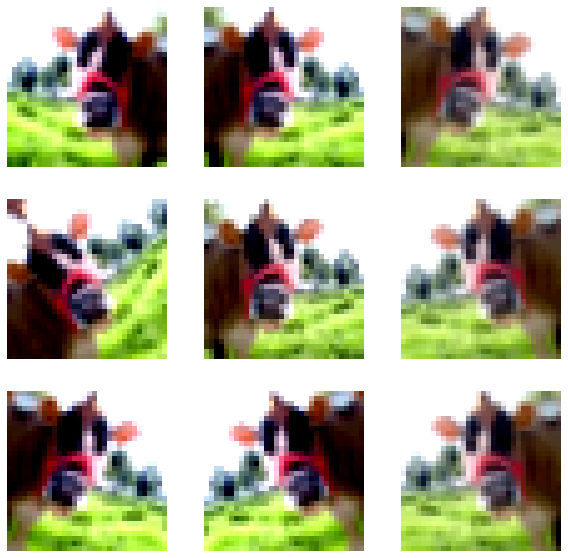

In [27]:
for images, labels in train_ds.take(1): 
    img = images[0]
    plt.figure(figsize=(10,10)) 
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1)
        #Augmented data : we need to pass a (x, 32,32,3) tensor => expand_ds
        augmented_data = data_augmentation(tf.expand_dims(img, 0), training=True)
        plt.imshow(augmented_data[0].numpy())
        plt.axis('off')


## transfer-learning workflow

In [28]:
# Download weights
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(32, 32, 3))
#Inference mode
base_model.trainable = False
    

In [29]:
def build_top(input_shape, num_classes): 
    #data augmentation
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    print(x)
    #normalization
    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    x = norm_layer(x)
    # get resnet model
    x = base_model(inputs, training=False)
    # include top part
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

top_model = build_top((32,32,3), 100)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='sequential_1/random_contrast_1/adjust_contrast/Identity:0', description="created by layer 'sequential_1'")


In [30]:
top_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
Total params: 23,792,612
Trainable params: 204,900
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
log_dir = "logs/fit/" + "resnet50_Adam_bs32_transfer_25epo"
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

top_model.compile(optimizer=keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=[tf.keras.metrics.CategoricalAccuracy(), "accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
top_model.fit(train_ds, epochs=15, callbacks=callbacks, validation_data=validation_ds)


Epoch 1/15


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,100] and labels shape [3200]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-31-02be4599150b>:9) ]] [Op:__inference_train_function_22896]

Function call stack:
train_function
